# Supplement figure --- seasonal spatial variation in continental and glacial

In [1]:
import pickle
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cmocean

%matplotlib inline

#### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202206/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202206/'
folder_cont = '/data/brogalla/run_storage/river-continental-202206/'
folder_seas = '/data/brogalla/run_storage/river-seasonal-202206/'

land_color = '#a9a7a2'

#### Load files:

In [3]:
# ANHA12 mesh:
mesh          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mesh.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mesh.variables['nav_lon'])
lat_ANHA12    = np.array(mesh.variables['nav_lat'])
e3t           = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e1t_base      = np.array(mesh.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base      = np.array(mesh.variables['e2t'])[0,imin:imax,jmin:jmax]
hdept         = np.array(mesh.variables['hdept'])[0,imin:imax,jmin:jmax]

In [4]:
# MN model grid:
ref         = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202206/ANHA12_ref-2002_20220422/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub     = np.array(ref.variables['nav_lon'])
lat_sub     = np.array(ref.variables['nav_lat'])
depth_model = np.array(ref.variables['deptht'])

#### Functions:

In [5]:
def load_Mn_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    path_seas = f'{folder_seas}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_seas}') as monthly_seas:
        dmn_seas = monthly_seas['dissolmn'].values[:,0,:,:,:]
    
    return dmn_ref, dmn_glac, dmn_cont, dmn_seas

In [6]:
def calculate_depth_weighted(var, levels=(0,16)):
    # Input arguments:
    # - var(t,z,y,x) --- variable 
    
    e3t_tile         = np.tile(e3t, (12,1,1,1))
    var_weighted     = var[:,levels[0]:levels[1],:,:]*e3t_tile[:,levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]):
    depth_bottom     = np.copy(hdept)
    depth_bottom[depth_bottom == 0] = np.nan
    # where bottom is deeper than levels[1], use depth of levels[1]
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1] 
                 
    # calculate average:
    var_weighted_ave = np.nansum(var_weighted, axis=1) / depth_bottom
    
    # Output:
    # - var_weighted_ave(t,y,x) --- depth-weighted average of variable for each horizontal grid location
    return var_weighted_ave

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{exp}-Mn_{ref}}{Mn_{ref}} \frac{1}{(factor_{exp} - 1)} \cdot 100\% $$

where $factor_{exp}$ is the proportion increase in river forcing in the experiment

In [7]:
def calculate_prop(dmn_riv_off, dmn_riv_on, factor=np.nan):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn in altered river experiment
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn in reference experiment
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off*factor)*100 
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

#### Calculations:

In [8]:
dmn_ref, dmn_glac, dmn_cont, dmn_seas = load_Mn_results()

depth_weighted_ref  = calculate_depth_weighted(dmn_ref, levels=(0,16))
depth_weighted_glac = calculate_depth_weighted(dmn_glac, levels=(0,16))
depth_weighted_cont = calculate_depth_weighted(dmn_cont, levels=(0,16))
depth_weighted_seas = calculate_depth_weighted(dmn_seas, levels=(0,16))

glacier_prop     = calculate_prop(depth_weighted_ref, depth_weighted_glac, factor=0.5)
continental_prop = calculate_prop(depth_weighted_ref, depth_weighted_cont, factor=0.5)
seasonal_prop    = calculate_prop(depth_weighted_ref, depth_weighted_seas, factor=11.8)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [9]:
# Mask small values:
ma_glac = np.ma.masked_where((glacier_prop < 0.05), glacier_prop)
ma_cont = np.ma.masked_where((continental_prop < 0.05), continental_prop)
ma_seas = np.ma.masked_where((seasonal_prop < 0.05), seasonal_prop)

#### Figures

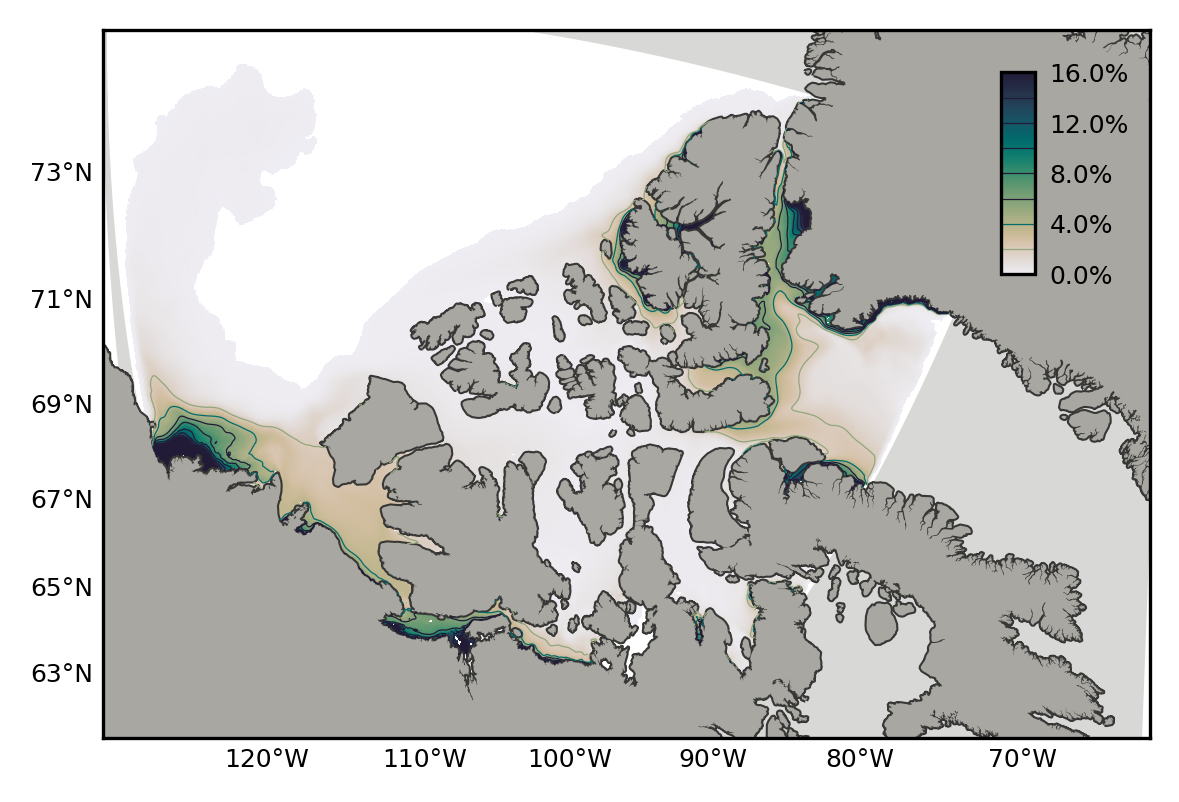

In [11]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-CAA.pickle','rb'))

#---------------------
x_model, y_model   = proj1(lon_sub, lat_sub)
x_ANHA12, y_ANHA12 = proj1(lon_ANHA12, lat_ANHA12)

CS1 = proj1.pcolormesh(x_model, y_model, np.ma.mean(ma_seas[:,:,:], axis=0), vmin=0, vmax=16, cmap=cmocean.cm.rain)

# Contour lines:
cmap_levels = [2,4,6,8,10,12,14,16]
seas = proj1.contour(x_model, y_model, np.ma.mean(ma_seas[:,:,:], axis=0), \
                     levels=cmap_levels, vmin=0, vmax=6, cmap=cmocean.cm.rain, linewidths=0.3, zorder=2) #colors='#3c3c3c'

# Draw domain boundaries:
# consider adding plus rimwidth of boundary 
ax1.fill_between(x_ANHA12[imin,:], y_ANHA12[imin,:], y_ANHA12[0,:], color='#d8d8d6')
ax1.fill_between(x_ANHA12[:,jmax], y_ANHA12[:,jmax], y_ANHA12[:,-1], color='#d8d8d6')
ax1.fill_between(x_ANHA12[imax,:], y_ANHA12[imax,:], y_ANHA12[-1,:], color='#d8d8d6')

# Colorbars:
cbaxes1 = fig.add_axes([0.79, 0.60, 0.025, 0.18])  
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, ticks=np.arange(0,20,4))
CBar1.add_lines(seas)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.1f}%' for i in CBar1.get_ticks()]);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/S5-seasonal-mean-field.jpg', bbox_inches='tight', dpi=300)

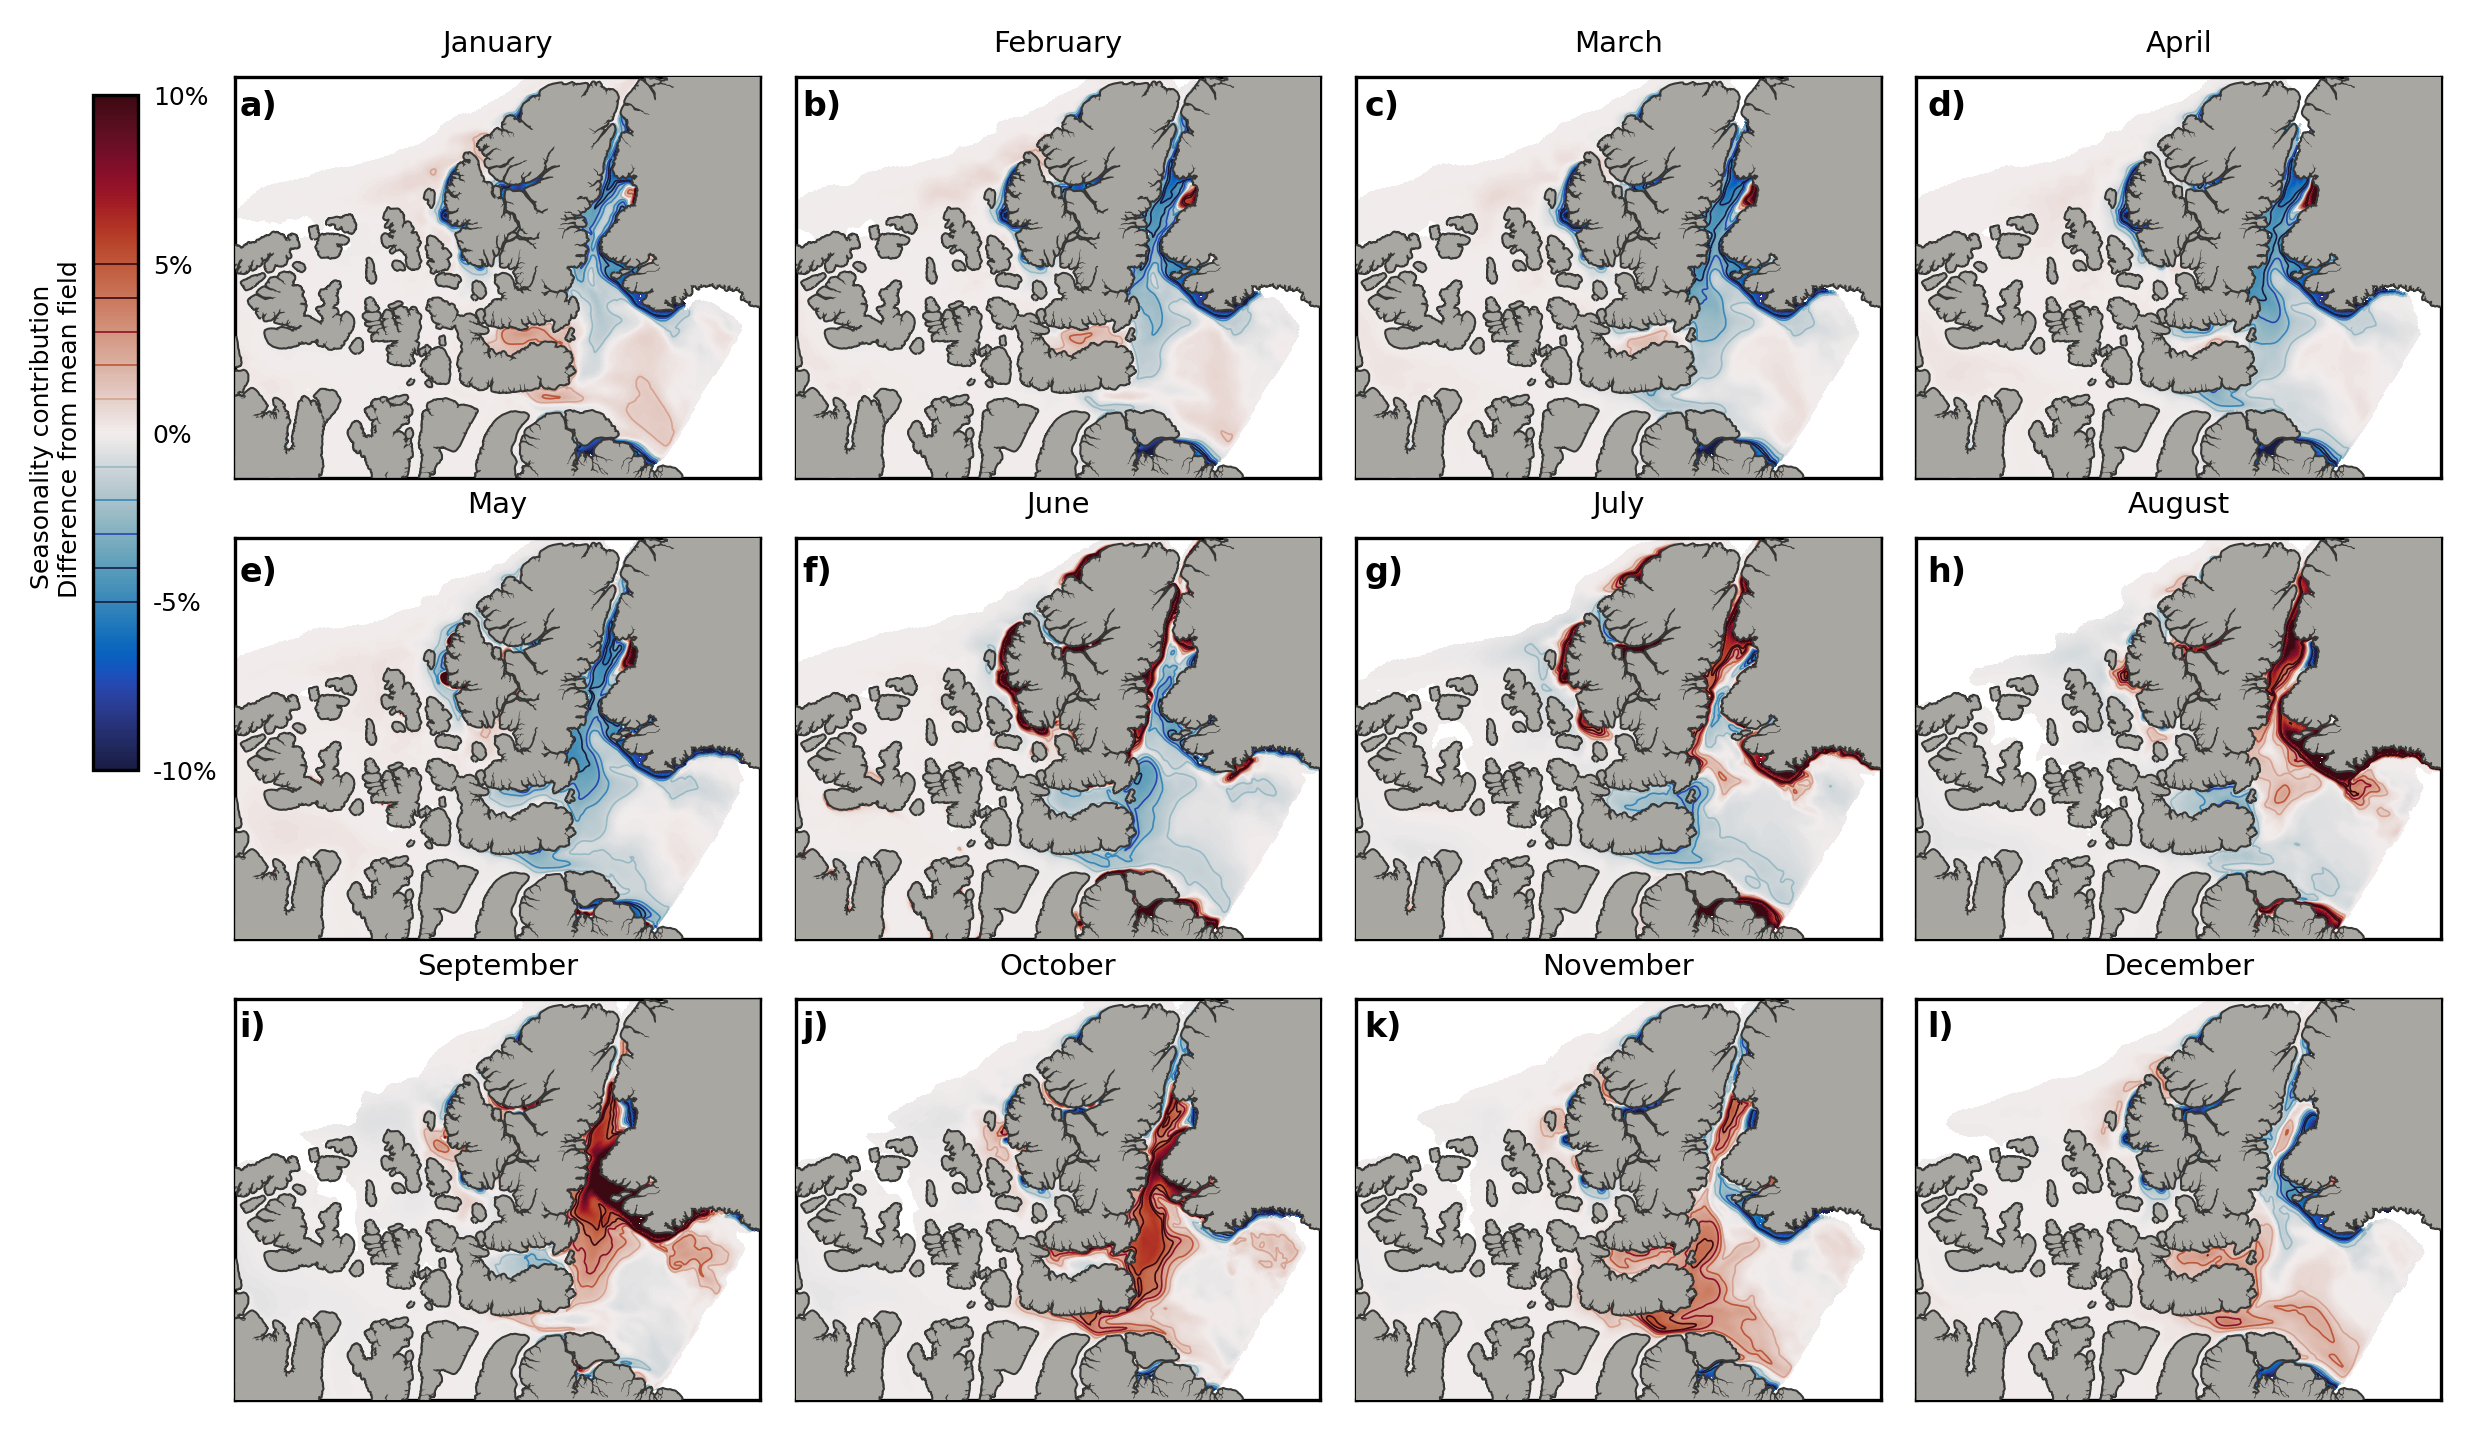

In [12]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/glacial-month-grid.pickle','rb'))

#---------------------
x_model1, y_model1 = proj1(lon_sub, lat_sub)

# Contour lines:
seas_levels = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
top = 10

months = np.arange(0,13,1)
titles = ['January','February','March','April','May','June','July',\
          'August','September','October','November','December']

for m,axis in enumerate(ax[:,:].ravel()):    
    CS1 = proj1.pcolormesh(x_model1, y_model1, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                           vmin=-top, vmax=top, cmap=cmocean.cm.balance, ax=axis)
    glac = proj1.contour(x_model1, y_model1, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                         levels=seas_levels, vmin=-4, vmax=4, cmap=cmocean.cm.balance, linewidths=0.4, ax=axis)
    axis.set_title(titles[m], fontsize=7)

# Colorbars:
cbaxes1 = fig.add_axes([-0.05, 0.48, 0.02, 0.5])  
CBar1   = plt.colorbar(CS1, ax=ax[0,0], cax=cbaxes1, ticks=np.arange(-10,15,5))
CBar1.add_lines(glac)
CBar1.set_label('Seasonality contribution \n Difference from mean field', labelpad=-45, fontsize=6)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.0f}%' for i in CBar1.get_ticks()]);

# add text labels:
fig.text(0.015, 0.965, 'a)', fontsize=8, weight='bold');
fig.text(0.265, 0.965, 'b)', fontsize=8, weight='bold');
fig.text(0.515, 0.965, 'c)', fontsize=8, weight='bold');
fig.text(0.765, 0.965, 'd)', fontsize=8, weight='bold');

fig.text(0.015, 0.62, 'e)', fontsize=8, weight='bold');
fig.text(0.265, 0.62, 'f)', fontsize=8, weight='bold');
fig.text(0.515, 0.62, 'g)', fontsize=8, weight='bold');
fig.text(0.765, 0.62, 'h)', fontsize=8, weight='bold');

fig.text(0.015, 0.283, 'i)', fontsize=8, weight='bold');
fig.text(0.265, 0.283, 'j)', fontsize=8, weight='bold');
fig.text(0.515, 0.283, 'k)', fontsize=8, weight='bold');
fig.text(0.765, 0.283, 'l)', fontsize=8, weight='bold');

plt.subplots_adjust(hspace=0.15)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/S6-seasonal-monthly-NS.jpg', bbox_inches='tight', dpi=300)

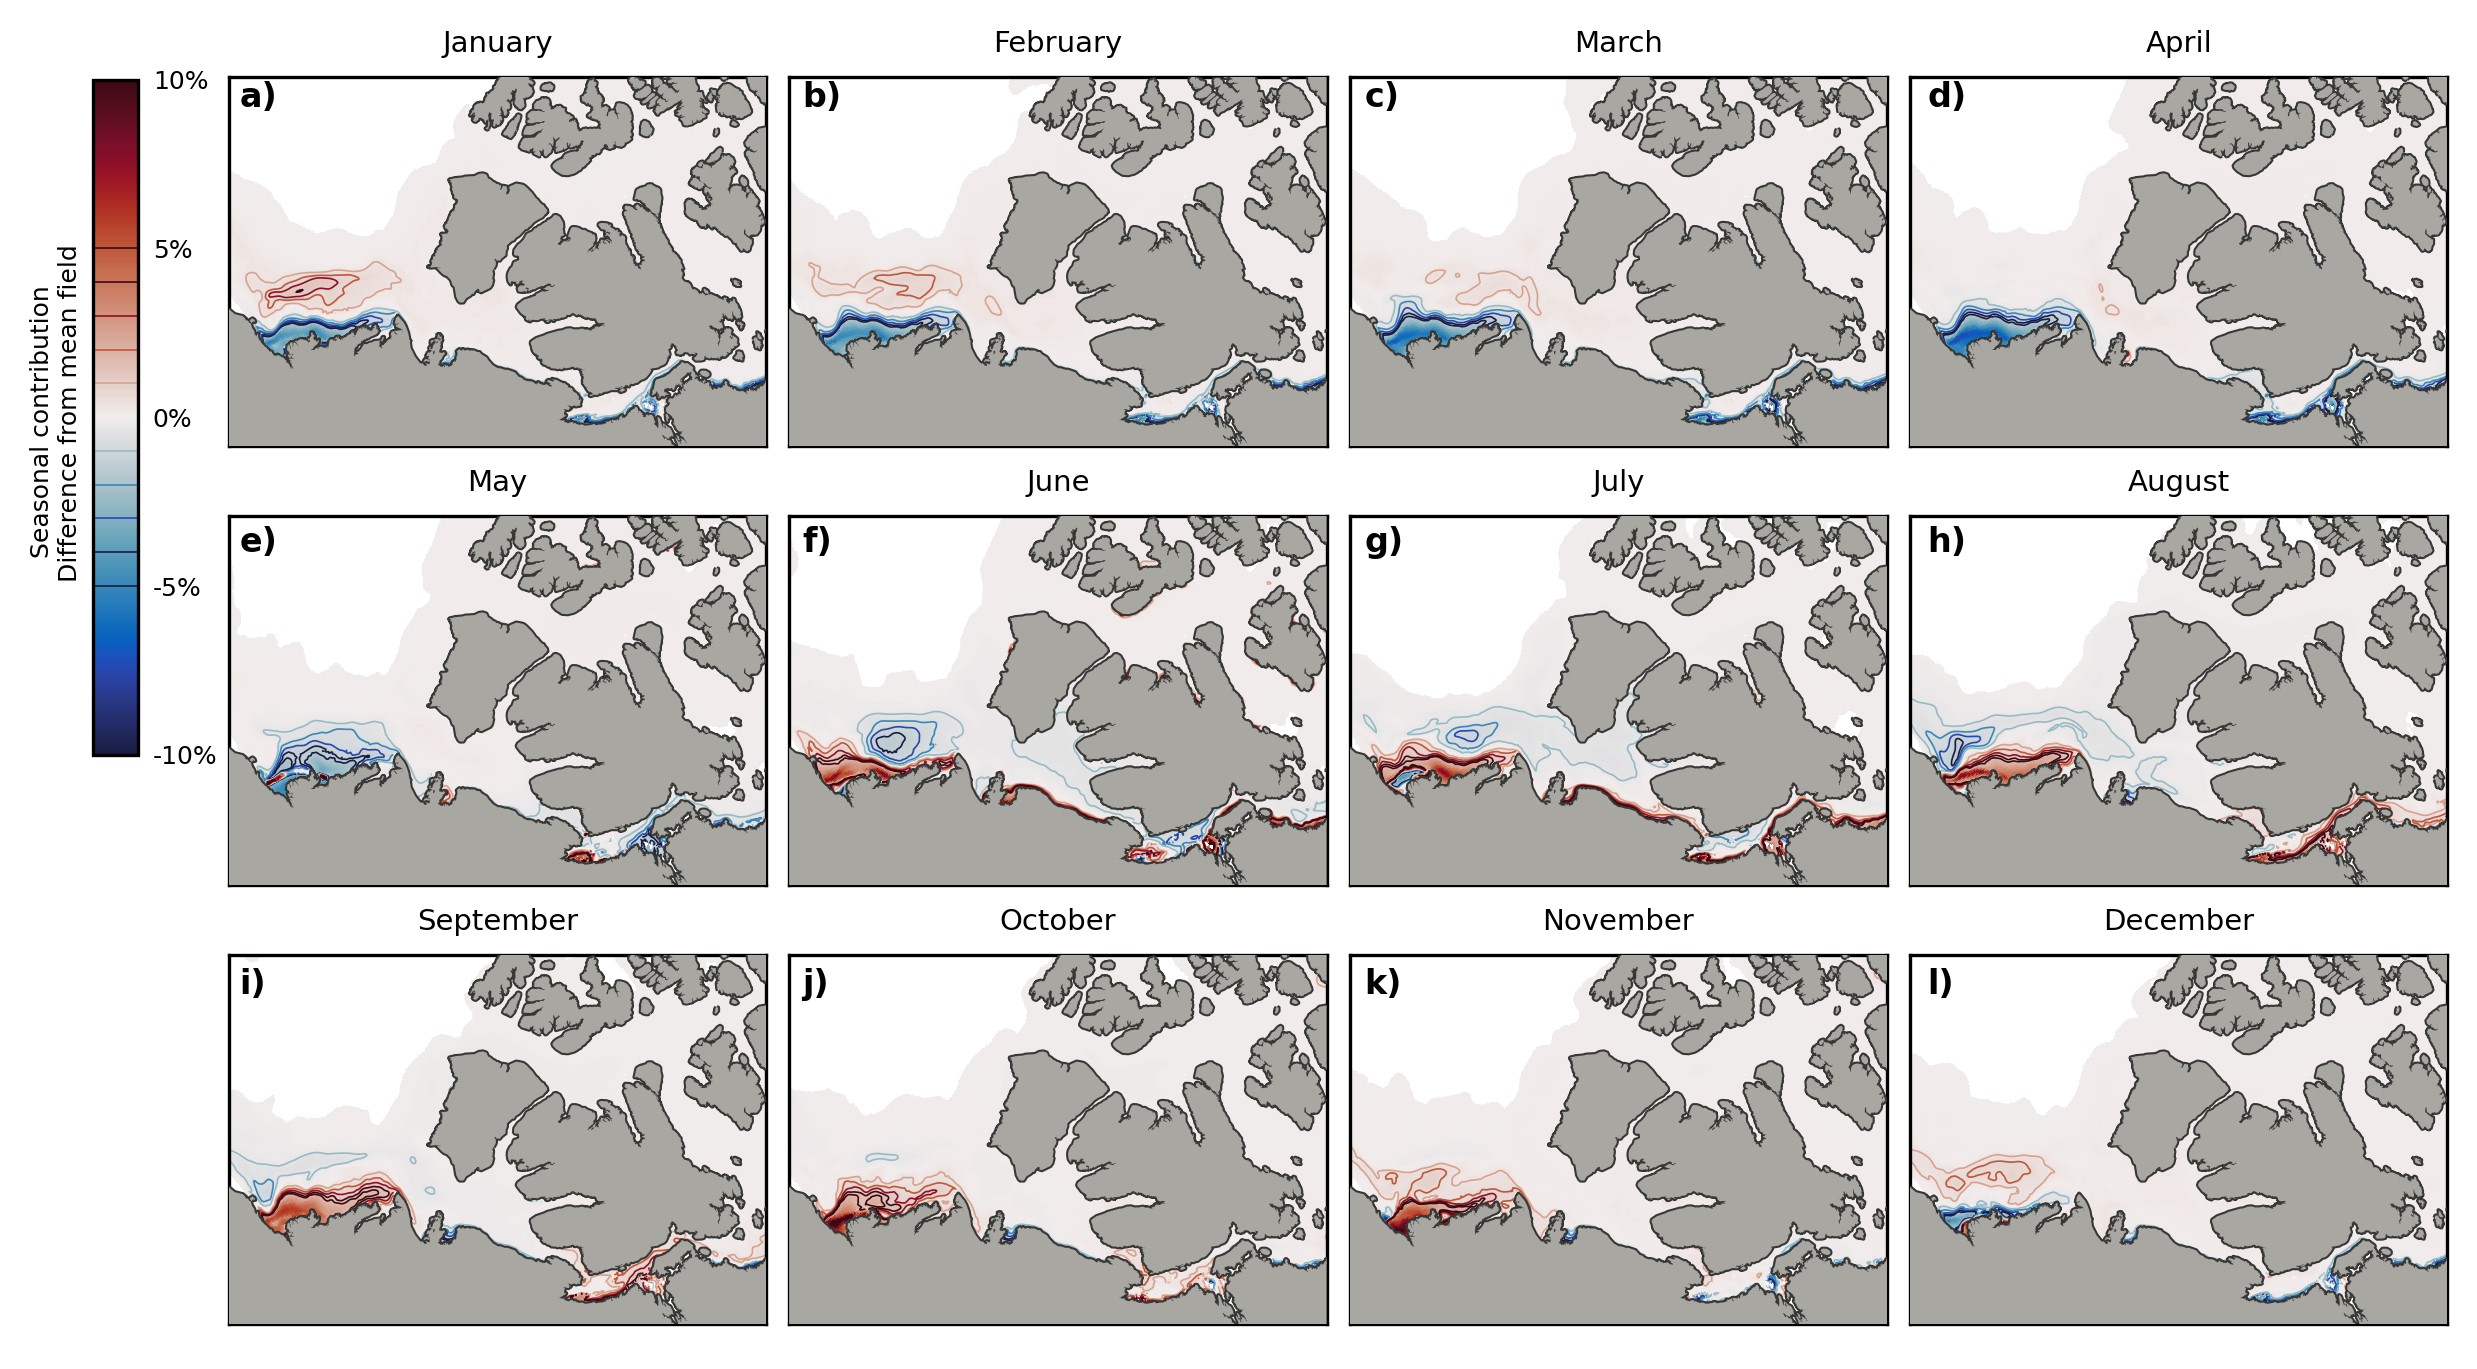

In [13]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/continental-month-grid.pickle','rb'))

#---------------------
x_model1, y_model1 = proj1(lon_sub, lat_sub)

# Contour lines:
seas_levels = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
top = 30

months = np.arange(0,13,1)
titles = ['January','February','March','April','May','June','July',\
          'August','September','October','November','December']

for m,axis in enumerate(ax[:,:].ravel()):    
    CS2 = proj1.pcolormesh(x_model1, y_model1, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                           vmin=-top, vmax=top, cmap=cmocean.cm.balance, ax=axis)
    cont = proj1.contour(x_model1, y_model1, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                         levels=seas_levels, vmin=-4, vmax=4, cmap=cmocean.cm.balance, linewidths=0.4, ax=axis)
    axis.set_title(titles[m], fontsize=7)
    
# Colorbars:
cbaxes1 = fig.add_axes([-0.05, 0.46, 0.02, 0.5])  
CBar1   = plt.colorbar(CS1, ax=ax[0,0], cax=cbaxes1, ticks=np.arange(-10,15,5))
CBar1.add_lines(glac)
CBar1.set_label('Seasonal contribution \n Difference from mean field', labelpad=-45, fontsize=6)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.0f}%' for i in CBar1.get_ticks()]);

# add text labels:
fig.text(0.015, 0.94, 'a)', fontsize=8, weight='bold');
fig.text(0.265, 0.94, 'b)', fontsize=8, weight='bold');
fig.text(0.515, 0.94, 'c)', fontsize=8, weight='bold');
fig.text(0.765, 0.94, 'd)', fontsize=8, weight='bold');

fig.text(0.015, 0.61, 'e)', fontsize=8, weight='bold');
fig.text(0.265, 0.61, 'f)', fontsize=8, weight='bold');
fig.text(0.515, 0.61, 'g)', fontsize=8, weight='bold');
fig.text(0.765, 0.61, 'h)', fontsize=8, weight='bold');

fig.text(0.015, 0.283, 'i)', fontsize=8, weight='bold');
fig.text(0.265, 0.283, 'j)', fontsize=8, weight='bold');
fig.text(0.515, 0.283, 'k)', fontsize=8, weight='bold');
fig.text(0.765, 0.283, 'l)', fontsize=8, weight='bold');

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/S7-seasonal-monthly-BS.jpg', bbox_inches='tight', dpi=300)